# Independent Component Analysis (ICA)

**Content Creator**: Maria de Fátima Dias



## Cocktail party problem

The cocktail party problem is a situation where there are multiple speakers in a room speaking at the same time, the signal that one captures is a mixture of signals and it might be important to separate the signals of each speaker. 
 
Suppose you have two microphones, as represented in the figure below and two persons that are speaking simultaneously and the signal generated by each one is uniformly distributed and independent. The  signal that each microphone captures depends on the distance to each one of the speakers, therefore if the microphones are not on the same position, then the signal captured by each microphone is different and a weighted combination of the sources.
For instance, if $x_i$ is the signal captured by the microphone i, the equation that describes $x_j$ is:

> $x_i = \sum_{j=1}^N a_{ji}s_j$ 

where $N$ is the number of sources, $s_j$ is the signal of the source $j$ and $a_{ij}$ represents the $j$-th source weight on the $i$ microphone.

This can be generalized, the microphones captured signal, $X$, is given by the equation:

> $X = As$
 
where $A$ represents each source weight for each microphone and has the following structure:
 
\begin{array}{|l|l|l|}
\hline
a11&a12 \\ \hline
a21&a22 \\ \hline
\end{array}
 

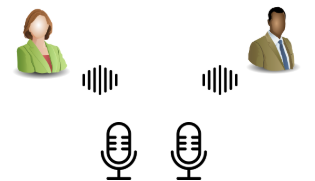

#### Exercice 1
 
Below you can play with the weights of each source, $a_{ij}$ on microphone captured signal, and check the impact of the weights on the signal collected.

In [ ]:
#@title
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive
import ipywidgets as widgets

def generate_random_distribution_sources(a11: float=2, a12: float=3, a21: float=4, a22: float=2):

  min_value = -5
  max_value = 5
  n_sources = 2
  number_samples = 2000

  sources = np.zeros((n_sources, number_samples))

  for source_i in range(n_sources):
    sources[source_i, :] = np.random.uniform(low=min_value, high=max_value, size=number_samples)

  transformation_matrix = np.asarray([[a11, a12],
                                      [a21, a22]])


  transformed_data = np.matmul(transformation_matrix, sources)
  
  f, ax = plt.subplots(1, 2, figsize=(25, 5))
  ax[0].plot(sources[0], sources[1], 'o')
  ax[1].plot(transformed_data[0], transformed_data[1], 'o')
  ax[0].set_title("Original distibution")
  ax[0].set_xlabel("Source 1")
  ax[0].set_ylabel("Source 2")
  ax[1].set_title("Captured distibution")
  ax[1].set_xlabel("Mixture 1")
  ax[1].set_ylabel("Mixture 2")
  return transformed_data, transformation_matrix

w = interactive(generate_random_distribution_sources, a11=(0.0,20.0,0.5), a12=(0.0,20.0,0.5), a21=(0.0,20.0,0.5), a22=(0.0,20.0,0.5))
display(w)

interactive(children=(FloatSlider(value=2.0, description='a11', max=20.0, step=0.5), FloatSlider(value=3.0, de…

#### FastICA

The example above is just a simulation, usually we do not know A and, in most of the cases, we will never know, yet one might be interested in recovering the independent sources from the mixture of the signals collected. 
 
The Independent Component Analysis (ICA) [1] is an algorithm that tries to estimate $A$, by finding the best linear transformation that maximizes the independence of the components, in a statistical point of view.
The problem is not closed-form and there are two ways to solve it:
 
1.  Maximization of the nongaussianity of the estimation:
     *  Kurtosis
     *  Negentropy
2.  Minimization of the mutual information:
     *  Maximum entropy
     *  Kullback‐Leibler divergence
 



#### Exercise 2

In the exercise below you will apply FastICA [2], an implementation of ICA, to the generated mixture above and check if the algorithm is able to separate the sources. The FastICA computes W, a estimation of A, compare both matrixes and drawn some conlusions.

A matrix:
[[2. 3.]
 [4. 2.]], 

W matrix:
[[-242.54226849 -386.17616233]
 [-507.75935077 -260.67076591]]


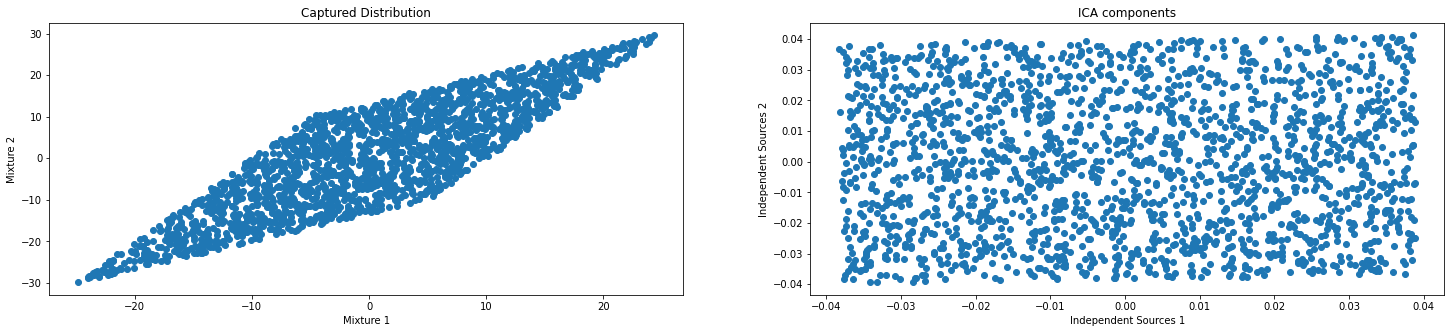

In [ ]:
#@title
from sklearn.decomposition import FastICA

X, A = w.result
ica_model = FastICA(n_components=2, random_state=0)
X_transformed = ica_model.fit_transform(X.T)
f, ax = plt.subplots(1, 2, figsize=(25, 5))
_ = ax[0].plot(X[0], X[1], 'o')
_ = ax[1].plot(X_transformed[:, 0], X_transformed[:, 1], 'o')
_ = ax[0].set_title("Captured Distribution")
_ = ax[1].set_title("ICA components")
ax[0].set_xlabel("Mixture 1")
ax[0].set_ylabel("Mixture 2")
ax[1].set_xlabel("Independent Sources 1")
ax[1].set_ylabel("Independent Sources 2")

print(f'A matrix:\n{A}, \n\nW matrix:\n{ica_model.mixing_}')


# EEG - Noise cleaning example

 
In the example above the ICA was used to separate the signals into independent sources. One might desire to use these independent sources or might be interested in removing one or more independent sources from the original signal. This latter case is commonly used to clean electroencephalogram (EEG) signals.

The captured EEG might have artifacts from other sources such as ECG, EMG and EOC. The signal that a scalp electrode captures might be given by the equation: 

$\mathrm{EEG}_{channel~captured}=\mathrm{EEG}_{channel}+\alpha ECG + \beta EOC + \gamma EMG$

where $\alpha$, $\beta$ and $\gamma$ are the respective contibution of ECG, EOC and EMG.

Thus, the EEG captured is, in fact, a mixture of signals that derive from other parts of the scalp but also from other parts of the body. ICA can be used to denoising the EEG signals by extracting the different independent components and removing the ones more similar to ECG, EOC and EMG. 

The standard approach to denoise EEG is to apply ICA to the signal collected by EEG electrodes and by visual inspection remove the components that most resemble ECG, EOG or EMG, and reconstruct the signal without these components. 

 
**In the example below you can find an application of the ICA to remove noise from the EEG collected during one-night sleep.** The data used in this notebook comes from the CAP Sleep Database [3] which is stored in the Physionet repository [4]. This database comprises several one-night polysomnographic recordings from different patients with different pathologies. The polysomnographic data includes at least three EEG channels (F3 or F4, C3 or C4 and O1 or O2, referred to A1 or A2), two EOG channels, three electromyographic EMG signals, respiration signals and the ECG. Along with the data is the manual annotation of sleep macrostructure according to the American Academy of Sleep Medicine (AASM) [5] scoring system.



In [ ]:
#@title
## Download data
import urllib.request 
import pandas as pd

url_data = 'https://github.com/mfmachado/adar/raw/main/resources/data_example.csv'
data_filename = 'data_example'
print(f'Downloading data file')
urllib.request.urlretrieve(url_data, data_filename)

df_all = pd.read_csv(url_data)

## Visualizing Data

In [ ]:
#@title
df_all.head(4)

,Fp2-F4,F4-C4,C4-P4,FP1-F3,F3-C3,C3-P3,P3-O1,C4-A1,ROC-LOC,EMG1-EMG2,ECG1-ECG2,HR,PLETH,Position,times,sleepstage
0,-9.004884e-07,-1.678877e-07,-2.213065e-06,-0.000004,1.724664e-06,0.000002,0.000002,-6.105128e-08,-0.000007,5.647131e-07,-0.000018,73.01442,-0.012704,3.0,7812.500000,S2
1,-2.823565e-06,-3.815629e-07,-2.762515e-06,-0.000004,-4.120879e-07,0.000002,-0.000001,-7.875615e-06,-0.000011,1.526252e-08,-0.000017,73.01442,0.001747,3.0,7812.515625,S2
2,-4.136142e-06,1.144689e-06,-2.289377e-07,-0.000009,-7.478632e-07,0.000003,0.000001,6.715641e-07,-0.000003,5.341880e-07,-0.000015,73.01442,0.017953,3.0,7812.531250,S2
3,-1.327839e-06,2.152015e-06,-3.678266e-06,-0.000009,-2.365690e-06,-0.000001,-0.000004,-5.769346e-06,0.000006,-6.868132e-07,-0.000016,73.01442,0.034143,3.0,7812.546875,S2


### Select the electrodes desired

In [ ]:
df_all = df_all.reset_index().drop(columns=["index"])

df = df_all[['times', 'sleepstage', 'Fp2-F4', 'F4-C4', 'C4-P4', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'C4-A1']]
df.head(4)

# Exclude the times, sleepstage and columns
columns_electrodes = [el for el in df.columns if el not in ["times", "sleepstage"]]

### Plotting data




#### Prepare the data

 
To improve the data visualization we should:
 
 
*  Transform the sleep stages from string into a numeric;
*  Normalize or standardize the data;
 
The latter is required because if the sleep stages vary between 0 and 4, and the maximum of the signal is 0.05 for instance, then it would be hard to see the signals when plotted with the sleep stages.

The Map of the sleep stage to an ID's is the following: 


*   W: 0
*   S1: 1
*   S2: 2
*   S3: 3
*   S4: 3
*   R: 4





In [ ]:
from sklearn.preprocessing import MinMaxScaler 

# Conversion sleep stages to Id's
sleep_stages_ids = {"W": 0, "S1": 1, "S2": 2, "S3":3, "S4":3, "R": 4}
sleep_stages_parsed = df["sleepstage"].apply(lambda x: sleep_stages_ids[x])
# Scale the signal
matrix_data_scaled = MinMaxScaler().fit_transform(df[columns_electrodes])*sleep_stages_parsed.max()

# The scaler the returns a matrix, convert the matrix back to a DataFrane
df_standard = pd.DataFrame(matrix_data_scaled, columns=columns_electrodes)

# Added column with times
df_standard["times"] = df.times

# Convert the sleep stage to ID's
df_standard["sleepstage"] = sleep_stages_parsed

### A signal per plot

#### Downsample to vizualize
To speed up the plot process you should tune the number of points to plot per second

In [ ]:
import seaborn as sns

In [ ]:
fs = int(1/(df_standard.times[1] - df_standard.times[0]))

# Number of points to plot per second, in this case all the points are being ploted
number_points_1_sec = 1/fs
marker_every_sec = int(number_points_1_sec*fs)
indexes_plot = np.arange(0, df.shape[0], marker_every_sec)

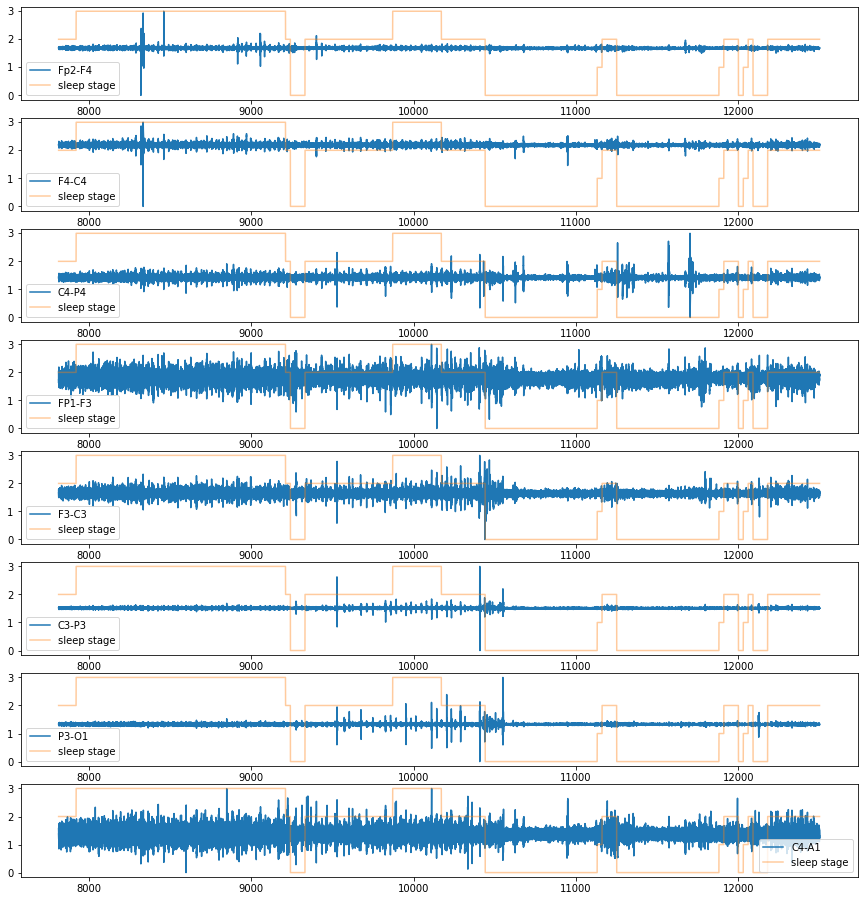

In [ ]:
f, ax = plt.subplots(len(columns_electrodes), 1, figsize=(15, 2*len(columns_electrodes)))
for i, column_name in enumerate(columns_electrodes):
  ax[i].plot(df_standard.iloc[indexes_plot]["times"], df_standard.iloc[indexes_plot][column_name], label=column_name, markevery=marker_every_sec)
  ax[i].plot(df_standard.iloc[indexes_plot]["times"], df_standard.iloc[indexes_plot]["sleepstage"], alpha=0.4, label="sleep stage", markevery=marker_every_sec)
  ax[i].legend()

### Multiple signals in one plot




In [ ]:
def plot_multiple(df_data, columns_plot, ax2, markevery=1):
  """
  This function receives a dataframe, the column names that one desires to plot 
  and the Axes plot
  """

  plt_columns = columns_plot.copy()
  # Plot also sleep stage
  plt_columns.append("sleepstage")

  n_rows = len(plt_columns)
  dmin = df_data[plt_columns].min().min()
  dmax = df_data[plt_columns].max().max()
  dr = (dmax - dmin) * 0.7  # Crowd them a bit.
  y0 = dmin
  y1 = (n_rows - 1) * dr + dmax
  ax2.set_ylim(y0, y1)
  ticklocs=[]
  segs = []
  ax2.set_xlim([df_data.times.min(), df_data.times.max()])
  ax2.set_ylim(y0, y1)

  for i, column_name in enumerate(plt_columns):
      segs.append(df_data.iloc[np.arange(0, df_data.shape[0], markevery)][["times", column_name]])
      ticklocs.append(i * dr)
  

  offsets = np.zeros((n_rows, 2), dtype=float)
  offsets[:, 1] = ticklocs

  lines = LineCollection(segs, offsets=offsets, transOffset=None)
  ax2.add_collection(lines)

  # Set the yticks to use axes coordinates on the y axis
  _ = ax2.set_yticks(ticklocs)
  # Set the yticks to use axes coordinates on the y axis
  ax2.set_yticks(ticklocs)
  ax2.set_yticklabels(plt_columns)

  ax2.set_xlabel('Time (s)')


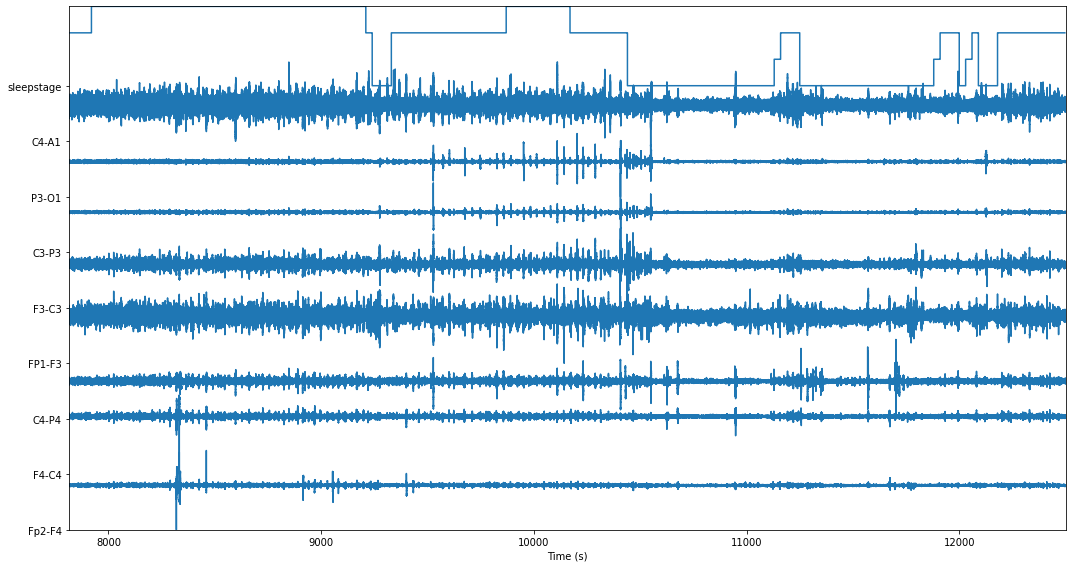

In [ ]:
from matplotlib.collections import LineCollection

f, ax_multiple = plt.subplots(1, 1, figsize=(15, 8)) 
plot_multiple(df_standard, columns_electrodes, ax_multiple, markevery=marker_every_sec)

plt.tight_layout()
plt.show()

## Apply ICA

In [ ]:
ica_model = FastICA(n_components=len(columns_electrodes), random_state=0)

# Apply ICA only to the electrodes (exclude sleep stages and times)
independent_sources = ica_model.fit_transform(df_standard[columns_electrodes])

# Apply the Min-Max Scaler
scaled_independent_sources = MinMaxScaler().fit_transform(independent_sources)*df_standard["sleepstage"].max()

# The fit_transform returns a matrix, convert it to dataframe
components_columns_name = [f'component#{el}' for el in range(len(columns_electrodes))]
df_sources = pd.DataFrame(data=scaled_independent_sources, columns=components_columns_name)
df_sources["times"] = df_standard["times"]
df_sources["sleepstage"] = df_standard["sleepstage"]
df_sources.head(4)

,component#0,component#1,component#2,component#3,component#4,component#5,component#6,component#7,times,sleepstage
0,1.609485,0.795588,1.091469,1.557948,1.587292,1.620942,1.676725,1.675245,7812.500000,2
1,1.600971,0.790029,1.091106,1.607619,1.651747,1.617731,1.666745,1.671136,7812.515625,2
2,1.597179,0.774791,1.093289,1.647876,1.560758,1.617782,1.674527,1.676083,7812.531250,2
3,1.608295,0.759750,1.077218,1.682627,1.631493,1.620032,1.661276,1.685462,7812.546875,2


##### Plotting the results side by side

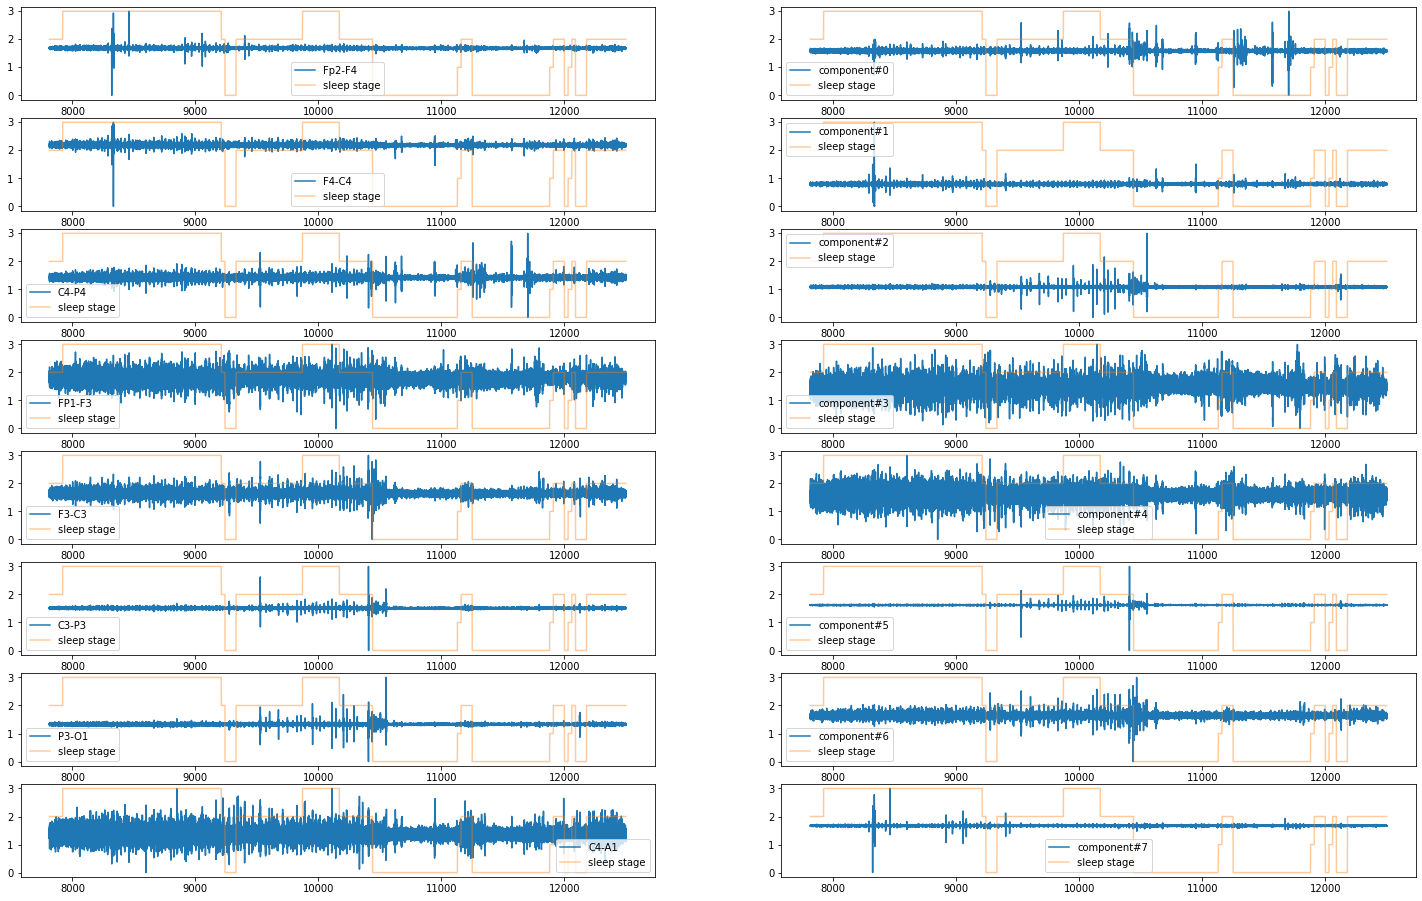

In [ ]:
f, ax = plt.subplots(len(columns_electrodes), 2, figsize=(25, 2*len(columns_electrodes)))
for j, (signal_type, df_sel, columns) in enumerate([("Original Signals", df_standard, columns_electrodes),
                                                    ("ICA componnets", df_sources, components_columns_name)]):
  for i, column_name in enumerate(columns):
    ax[i, j].plot(df_sel.iloc[indexes_plot]["times"], df_sel.iloc[indexes_plot][column_name], label=column_name, markevery=marker_every_sec)
    ax[i, j].plot(df_sel.iloc[indexes_plot]["times"], df_sel.iloc[indexes_plot]["sleepstage"], alpha=0.4, label="sleep stage", markevery=marker_every_sec)
    ax[i, j].legend()

##### Other strategy of plotting side by side

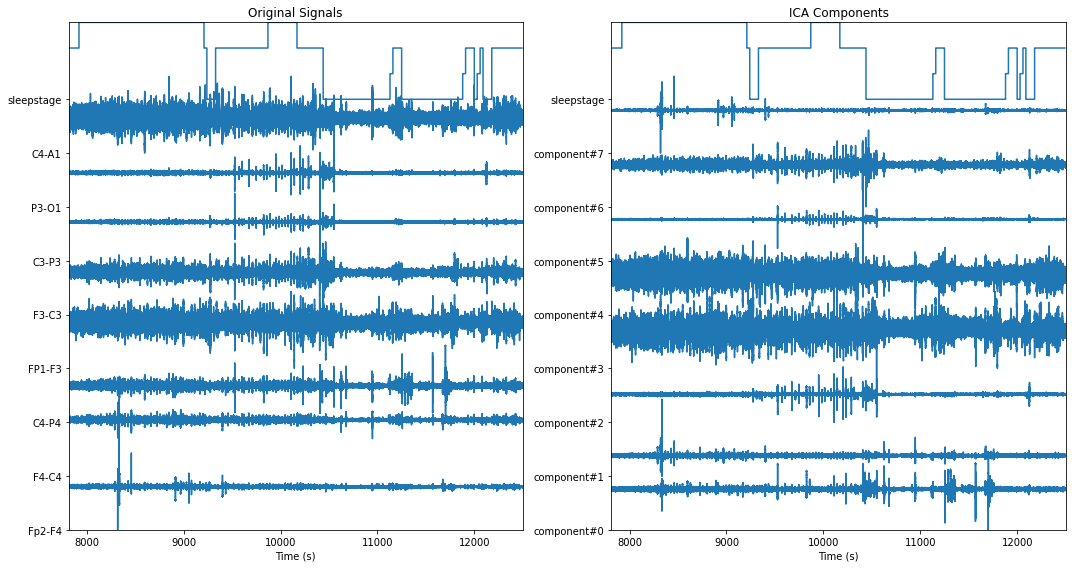

In [ ]:
f, ax_ica = plt.subplots(1, 2, figsize=(15, 8)) 
plot_multiple(df_standard, columns_electrodes, ax_ica[0], markevery=marker_every_sec)
plot_multiple(df_sources, components_columns_name, ax_ica[1], markevery=marker_every_sec)
ax_ica[0].set_title("Original Signals")
ax_ica[1].set_title("ICA Components")
plt.tight_layout()
plt.show()

See a smaller portion of the signal

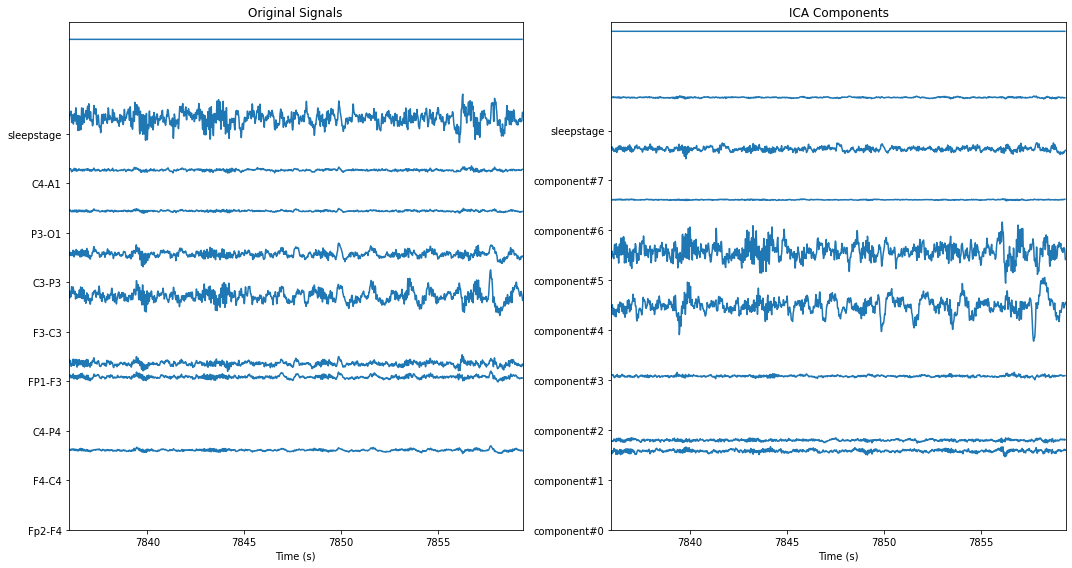

In [ ]:
f, ax_ica = plt.subplots(1, 2, figsize=(15, 8)) 
plot_multiple(df_standard.iloc[1500:3000], columns_electrodes, ax_ica[0])
plot_multiple(df_sources.iloc[1500:3000], components_columns_name, ax_ica[1])
ax_ica[0].set_title("Original Signals")
ax_ica[1].set_title("ICA Components")
plt.tight_layout()
plt.show()

## Denoising with ICA

In the example below you can see the effect on the reconstructed signal when a single component is considered as noise.

In [ ]:
def remove_a_component(model_ica, df_indp_sources, column_name_component_rejected):

  df_sources_clean = df_indp_sources.copy()
  df_sources_clean[column_name_component_rejected] = 0

  # Times and sleep stages cannot be used in the reconstruction, therefore they should be removed 
  cols = [el for el in df_sources_clean.columns if el not in ["times", "sleepstage"]]
  X_restored = model_ica.inverse_transform(df_sources_clean[cols])
  X_restored_scaled = MinMaxScaler().fit_transform(X_restored)*df_indp_sources["sleepstage"].max()
  return  X_restored_scaled

def plot_with_wihout_component(model_ica, df_indp_sources, column_name_component_rejected, data_original):
  _ = plt.clf()
  print(f'Removing component {column_name_component_rejected}, this might take a few seconds.')
  columns_orig = [el for el in data_original.columns if el not in ["times", "sleepstage"]]
  sources_clean = remove_a_component(model_ica, df_indp_sources, column_name_component_rejected)
  df_sources_clean = pd.DataFrame(data=sources_clean, columns=columns_orig)

  df_sources_clean["times"] = data_original["times"]
  df_sources_clean["sleepstage"] = data_original["sleepstage"]

  f, ax_clean = plt.subplots(1, 3, figsize=(25, 15)) 
  plot_multiple(df_standard, columns_electrodes, ax_clean[0], markevery=marker_every_sec)
  plot_multiple(df_indp_sources, components_columns_name, ax_clean[1], markevery=marker_every_sec)
  plot_multiple(df_sources_clean, columns_electrodes, ax_clean[2], markevery=marker_every_sec)
  ax_clean[0].set_title("Original Signals")
  ax_clean[1].set_title("ICA Components")
  ax_clean[2].set_title("Cleaned Signals")
  _ = plt.tight_layout()
  plt.show()


#### Exercice 3: Interact with the widget to learn about the effect of considering an ICA component as noise.

In [ ]:
from IPython.html.widgets import interact, fixed
# plot_with_wihout_component(ica_model, df_sources, df_sources.columns[3], df_standard)
interact(plot_with_wihout_component, column_name_component_rejected=components_columns_name, model_ica=fixed(ica_model), df_indp_sources=fixed(df_sources), data_original=fixed(df_standard));

interactive(children=(Dropdown(description='column_name_component_rejected', options=('component#0', 'componen…

## Bibliography

[1]	Hyvarinen, Aapo, J. Karhunen, and E. Oja. "Independent component analysis and blind source separation", 2001

[2]	Hyvarinen, Aapo. "Fast and robust fixed-point algorithms for independent component analysis." IEEE transactions on Neural Networks 10.3, 1999

[3]	“CAP Sleep Database v1.0.0.” [Online]. Available: https://physionet.org/content/capslpdb/1.0.0/. [Accessed: 10-Feb-2021]. 

[4]	G. B. Moody, “PhysioNet,” in Encyclopedia of Computational Neuroscience, 2014. 

[5]	R. B. Berry et al., “The AASM Manual for the Scoring of Sleep and Associated Events,” Journal of Clinical Sleep Medicine. 2018. 
